# Проект: Анализ обращений в поддержку (кластеризация)

В службу поддержки компании, зарабатывающей на продаже и доставке своих продуктов клиентам, регулярно обращаются клиенты с разного рода вопросами. Компания крупная, клиентов много и обращений тоже поступает много. Для того, чтобы улучшить качество предоставляемого сервиса, компания просит объединить поступающие обращения в группы по похожести. Из этих групп можно будет понять, на что в основном жалуются клиенты и какие части сервиса нужно улучшить.

Задачи проекта:

1. Обработать данные, очистив их от лишних слов и символов.
2. Обучить эмбеддинги слов с помощью Word2Vec.
3. Векторизовать и кластеризовать все обращения, подобав лучшие параметры кластеризации.
4. Визуализировать полученные кластеры обращений.

## Загрузка библиотек и данных

In [26]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re

from collections import Counter
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import STOPWORDS

from nltk.corpus import words, stopwords
from nltk.metrics.distance import edit_distance
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import wordpunct_tokenize

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

from tqdm.auto import tqdm
from wordcloud import WordCloud

In [2]:
nltk.download('wordnet')
nltk.download('words')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ekaterinazgurskaya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/ekaterinazgurskaya/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ekaterinazgurskaya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
data = pd.read_csv('customer_support.csv')
data.head()

,text
0,question about cancelling order {{Order Number}}
1,i have a question about cancelling oorder {{Or...
2,i need help cancelling puchase {{Order Number}}
3,I need to cancel purchase {{Order Number}}
4,"I cannot afford this order, cancel purchase {{..."


## Предобработка данных

Можно заметить, что в данных вся личная информация о пользователях заменена на специальные ключевые слова: `{{Order Number}}` и т.д. Эти строки не содержат в себе полезной информации и даже могут помешать кластеризации, поэтому необходимо их удалить:

In [4]:
def remove_private_data(texts):
    clean_texts = []
    for text in texts:
        clean_texts.append(re.sub(pattern=r'{{.*?}}', repl='', string=text).strip())
    return clean_texts

In [5]:
texts = remove_private_data(data.text)
texts[:5]

['question about cancelling order',
 'i have a question about cancelling oorder',
 'i need help cancelling puchase',
 'I need to cancel purchase',
 'I cannot afford this order, cancel purchase']

Введем функцию `vocab_size`. Она принимает список текстов и возвращает число уникальных слов в нем. В процессе предобработки данных будем смотреть насколько уменьшится число уникальных слов.

In [6]:
def vocab_size(texts):
    vocab = set()
    for text in texts:
        if isinstance(text, list):
            vocab |= set(text)
        else:
            vocab |= set(text.split())

    return len(vocab)

In [7]:
vocab_size(texts)

3160

В этом проекте мы будем использовать Word2Vec для работы с текстом, так как уникальных слов в словаре не очень много и простой метод подойдет. Очистим текст следующими способами для уменьшения размера словаря:
- удалим всю пунктуацию и числа
- приведем текст к нижнему регистру
- поделим тексты на слова по пробелам и лемматизируем каждое слово
- удалим все стоп-слова
- исправим опечатки в словах
- удалим слишком редкие слова

### Удалим всю пунктуацию и числа:

In [8]:
def remove_nonalpha(texts):
    clean_texts = []
    for text in texts:
        clean_texts.append(re.sub(r'[^a-zA-Z\s]', '', text))
    return clean_texts

In [9]:
texts = remove_nonalpha(texts)
texts[:5]

['question about cancelling order',
 'i have a question about cancelling oorder',
 'i need help cancelling puchase',
 'I need to cancel purchase',
 'I cannot afford this order cancel purchase']

In [10]:
vocab_size(texts)

2824

### Токенизируем, лемматизируем и приведем к нижнему регистру:

In [11]:
def lemmatize_corpus(texts):
    lemmatizer = WordNetLemmatizer()
    clean_texts = []
    for text in texts:
        words = wordpunct_tokenize(text.lower())
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        clean_texts.append(lemmatized_words)
    return clean_texts

In [12]:
texts = lemmatize_corpus(texts)
texts[:5]

[['question', 'about', 'cancelling', 'order'],
 ['i', 'have', 'a', 'question', 'about', 'cancelling', 'oorder'],
 ['i', 'need', 'help', 'cancelling', 'puchase'],
 ['i', 'need', 'to', 'cancel', 'purchase'],
 ['i', 'cannot', 'afford', 'this', 'order', 'cancel', 'purchase']]

In [13]:
vocab_size(texts)

2761

### Удалим стоп-слова:

Почти в каждом тексте видим местоимения, предлоги, союзы (стоп-слова), которые не несут в себе никакого смысла, но при этом увеличивают длину каждого предложения. Удалим их из корпуса. Для получения набора стоп-слов объединим слова из `nltk.corpus.stopwords` и `gensim.parsing.preprocessing.STOPWORDS`.

In [14]:
stopwords = STOPWORDS | set(stopwords.words('english'))
len(stopwords)

390

In [15]:
def remove_stopwords(texts, stopwords):
    clean_texts = []
    for words in texts:
        clean_texts.append([word for word in words if word not in stopwords])
    return clean_texts

In [16]:
texts = remove_stopwords(texts, stopwords)
texts[:5]

[['question', 'cancelling', 'order'],
 ['question', 'cancelling', 'oorder'],
 ['need', 'help', 'cancelling', 'puchase'],
 ['need', 'cancel', 'purchase'],
 ['afford', 'order', 'cancel', 'purchase']]

In [17]:
vocab_size(texts)

2648

### Исправим опечатки в словах:

Видим, что есть слова, которые содержат опечатки. Исправим их следующим способом: возьмем множество всех английских слов и будем менять каждое слово в корпусе на ближайшее к нему английское слово. Тогда если слово не содержит опечаток, оно не поменяется, а если содержит, то опечатка должна исправиться. Расстояние будем считать согласно [расстоянию Левенштейна](https://ru.wikipedia.org/wiki/Расстояние_Левенштейна) (импортируем из `nltk.metrics.distance`).

Множество всех слов возьмем из `nltk.corpus.words`, для данного проекта нам вполне хватит.

In [18]:
all_words = words.words()
len(all_words)

236736

In [20]:
def preprocess(words):
    fixed_words = []
    for word in words:
        if word in all_words:
            fixed_words.append(word)
        else:
            result = [
                (edit_distance(word, w), w)
                for w in all_words
                if w[0] == word[0] and w[-1] == word[-1] and abs(len(w) - len(word)) < 3
            ]
            if len(result) == 0:
                continue
            distances, words = zip(*result)
            fixed_words.append(words[np.argmin(distances)])

    return fixed_words


def fix_typos(texts):
    return [preprocess(text) for text in texts]

In [21]:
texts = fix_typos(tqdm(texts))
texts[:5]

  0%|          | 0/26707 [00:00<?, ?it/s]

[['question', 'canalling', 'order'],
 ['question', 'canalling', 'order'],
 ['need', 'help', 'canalling', 'purchase'],
 ['need', 'cancel', 'purchase'],
 ['afford', 'order', 'cancel', 'purchase']]

In [22]:
vocab_size(texts)

1558

Число уникальных слов уменьшилось, но так как в словаре nltk присутствуют далеко не все английские слова, часть правильных слов тоже поменялась. Например, `cancelling -> canalling`. Однако, это не страшно, потому что для Word2Vec не важно, как пишется слово. Главное, чтобы все слова с одинаковым написанием имели одинаковый смысл.

### Удалим редкие слова:

In [35]:
# удалим все слова, которые встретились меньше, чем в 4 текстах
def remove_rare_words(texts):
    word_counts = Counter()
    for text in texts:
        unique_words = set(text)
        word_counts.update(unique_words)

    common_words = {word for word, count in word_counts.items() if count >= 4}

    clean_texts = [
        [word for word in text if word in common_words]
        for text in texts
    ]
    return clean_texts

In [36]:
texts = remove_rare_words(texts)
texts[:5]

[['question', 'canalling', 'order'],
 ['question', 'canalling', 'order'],
 ['need', 'help', 'canalling', 'purchase'],
 ['need', 'cancel', 'purchase'],
 ['afford', 'order', 'cancel', 'purchase']]

In [37]:
vocab_size(texts)

526

Итак, в процессе предобработки данных мы снизили число уникальных слов с 3160 (изначальный набор) до 526, оставив только те слова, которые несут в себе наиболее важную информацию.

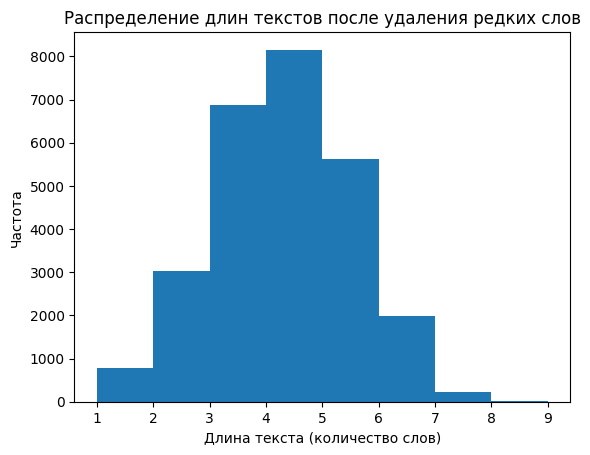

In [39]:
# посмотрим на распределение длин полученных текстов
lens = [len(text) for text in texts]
plt.hist(lens, bins=8)
plt.title('Распределение длин текстов после удаления редких слов')
plt.xlabel('Длина текста (количество слов)')
plt.ylabel('Частота')
plt.show()

Видим, что тексты довольно короткие (в среднем 4 слова).

## Обучение Word2Vec

Чтобы кластеризовывать тексты, необходимо привести их к векторному виду. Для этого можно использовать BoW или TF-IDF, однако их проблема в том, что они не смогут учитывать синонимы. Так как у нас довольно короткие тексты, мы можем векторизовать их, усреднив эмбеддинги слов. Для получения эмбеддингов, учитывающих синонимы, обучим Word2Vec.

In [42]:
def train_w2v(texts):
    model = Word2Vec(
        texts,
        vector_size=100,
        min_count=0,
        window=3,).wv
    return model

In [43]:
model = train_w2v(texts)

Имея обученный Word2Vec, можем векторизовать тексты. Как и было сказано выше, для векторизации текста усредним эмбеддинги его слов.

In [44]:
def get_text_embedding(words, w2v_model):
    embeddings = np.array([model.get_vector(word) for word in words if word in w2v_model])
    embedding = np.mean(embeddings, axis=0)
    return embedding

In [45]:
w2v_text_embeddings = np.stack([get_text_embedding(words, model) for words in texts])
w2v_text_embeddings.shape

(26707, 100)

## Кластеризация с K-Means

Кластеризуем полученные векторы текстов при помощи K-Means чтобы сохранить центры кластеров и извлечь тексты, представляющие каждый кластер.

K-Means требует указания числа кластеров, которые мы будем перебирать и выберем лучшее число с точки зрения метрики silhouette score (коэффициент силуэта), которая используется для оценки качества кластеризации и измеряет, насколько хорошо объект совпадает с его собственным кластером по сравнению с другими кластерами.

Число кластеров будем перебирать в диапазоне от 3 до 30.

In [54]:
def find_best_k(text_embeddings):
    all_scores = {}
    for i in tqdm(range(3, 31)):
        kmeans = KMeans(n_clusters=i, random_state=42)
        labels = kmeans.fit_predict(text_embeddings)
        score = silhouette_score(text_embeddings, labels)
        all_scores[i] = score

    best_k = max(all_scores, key=all_scores.get)
    return best_k

In [55]:
best_k = find_best_k(w2v_text_embeddings)
best_k

  0%|          | 0/28 [00:00<?, ?it/s]

11

Обучаем K-Means с полученным значением числа кластеров и смотрим на результат.

In [56]:
kmeans = KMeans(n_clusters=best_k)
clusters = kmeans.fit_predict(w2v_text_embeddings)

cluster_counts = Counter(clusters)

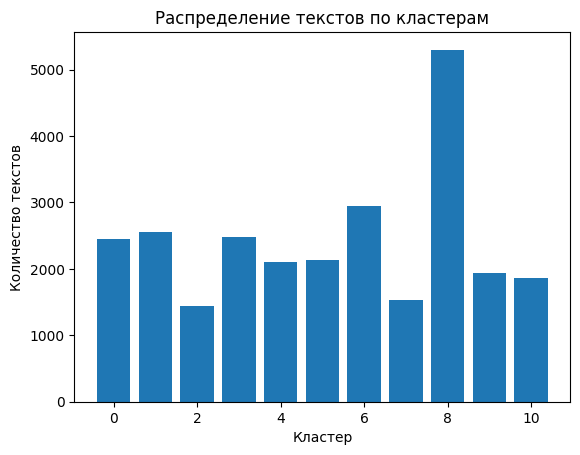

In [57]:
plt.bar(cluster_counts.keys(), cluster_counts.values())
plt.title('Распределение текстов по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Количество текстов')
plt.show()

In [58]:
score = silhouette_score(w2v_text_embeddings, clusters)
print('Итоговое значение Silhouette Score:', score)

Итоговое значение Silhouette Score: 0.3083498


Дополнительно визуализируем полученные кластеры с помощью t-SNE. Так как текстов очень много, возьмем случайные 2000 для визуализации.

In [59]:
n = 2000
idxs = np.random.choice(range(len(w2v_text_embeddings)), n)
data_2d = TSNE(
    n_components=2, learning_rate='auto',
    init='random', perplexity=3
).fit_transform(w2v_text_embeddings[idxs])
data_2d.shape

(2000, 2)

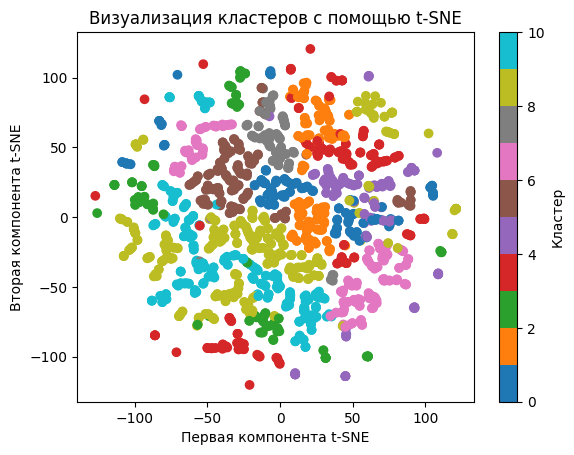

In [61]:
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=clusters[idxs], cmap='tab10')
plt.title('Визуализация кластеров с помощью t-SNE')
plt.xlabel('Первая компонента t-SNE')
plt.ylabel('Вторая компонента t-SNE')
plt.colorbar(label='Кластер')
plt.show()

Распределение объектов получилось довольно адекватным, как и значение Silhouette Score и вид t-SNE. Значит, все в порядке, можно смотреть на сами кластеры.

## Анализ кластеров

Для анализа кластеров посмотрим на несколько текстов, лежащих наиболее близко к центрам. Именно эти тексты будут лучше всего описывать кластер.

In [64]:
def find_nearest(embedding, text_embeddings, k=10):
    # Преобразуем embedding к нужной форме (добавляем одну размерность)
    embedding = embedding.reshape(1, -1)
    # Вычисляем косинусную близость между embedding и text_embeddings
    similarities = cosine_similarity(embedding, text_embeddings)
    # Получаем индексы k самых ближайших текстов
    nearest_idxs = np.argsort(similarities[0])[-k:][::-1]
    return nearest_idxs

In [65]:
for i, center in enumerate(kmeans.cluster_centers_):
    nearest_idxs = find_nearest(center, w2v_text_embeddings, k=10)
    nearest_texts = list(data.text[nearest_idxs])
    print(f'Topic № {i}')
    for text in nearest_texts:
        print(text)
    print()

Topic № 0
how to see your goddamn reimbursement policy?
need to see in what situations can i ask for a reimbursement
I want to obtain a reimbursement of money
I try to see in what situations can I request reimbursements
I want to obtain refunds of my money
I need to demnand reimbursements of money
in which situations can I ask for a goddamn reimbursement?
is it possible to demand refunds of my money?
what do I need to do to demand a refund of my money?
i try to demand a reimbursement of my money

Topic № 1
I forgot the fucking pass of my account, I need to reset it
is it possible to use the bloody standard profile?
I need assistanec retrieving my account key
where to reset my fucking account pass ?
where can i retrieve my fucking accopunt pass
can uhelp me to retrieve the pass of my account
i try to recover my account pass
I need assistance to retrieve the password of my account
I need to use the platinum profile, can you help me?
i need help to use the platinum progile

Topic № 2
can 

Видим, что тексты в разных кластерах действительно отличаются по темам обращений. Однако, так оценивать темы довольно сложно. Лучше визуализируем кластеры с помощью облаков слов. Они будут показывать, какие слова встречаются чаще других в каждом кластере.

In [66]:
def create_lda_wordcloud(texts):
    wordcloud = WordCloud(
        width=1600, height=800, max_words=200, background_color='white', collocations=False
    ).generate(' '.join(texts))
    plt.figure(figsize=(7, 5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

Topic № 0


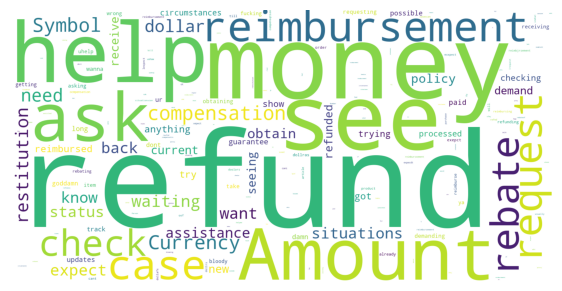

Topic № 1


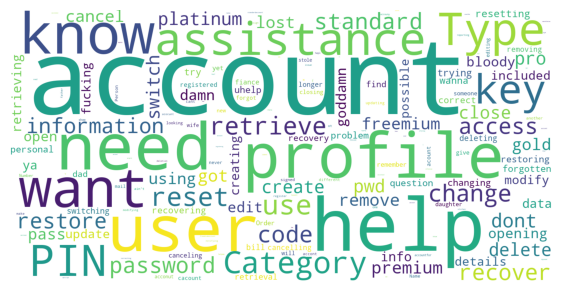

Topic № 2


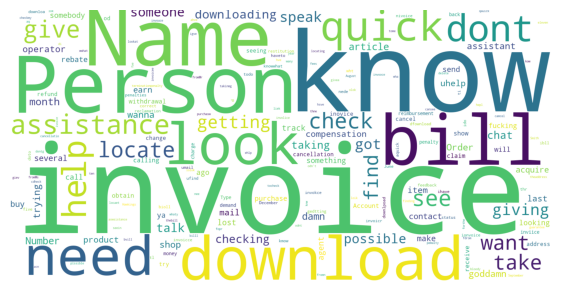

Topic № 3


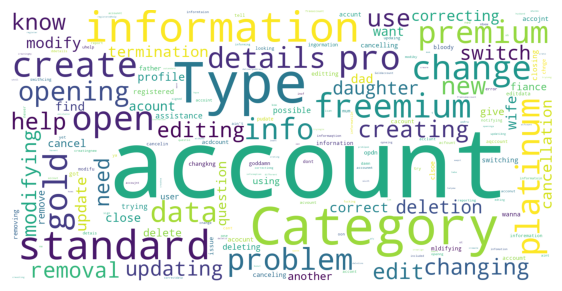

Topic № 4


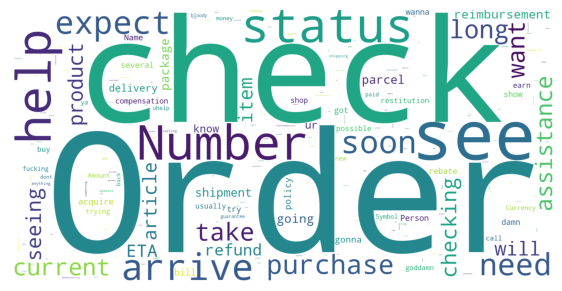

Topic № 5


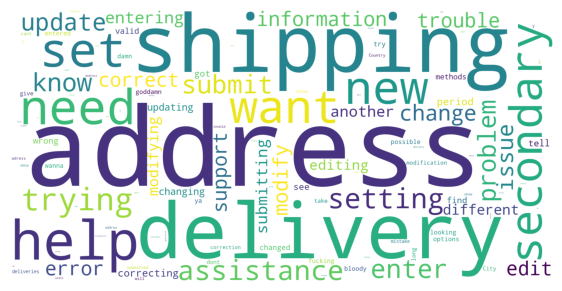

Topic № 6


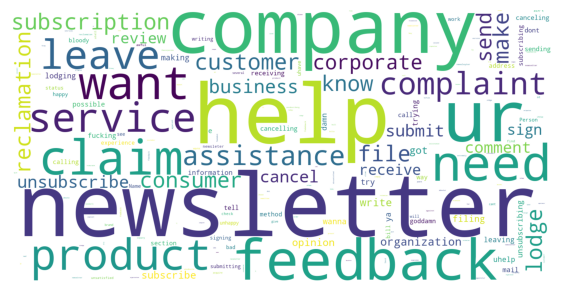

Topic № 7


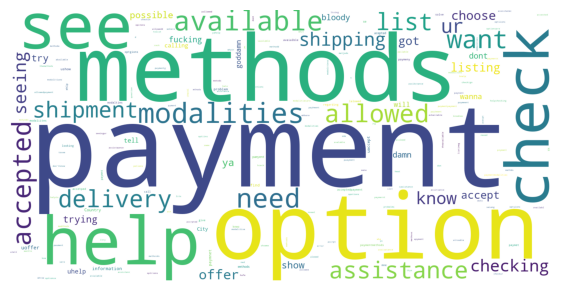

Topic № 8


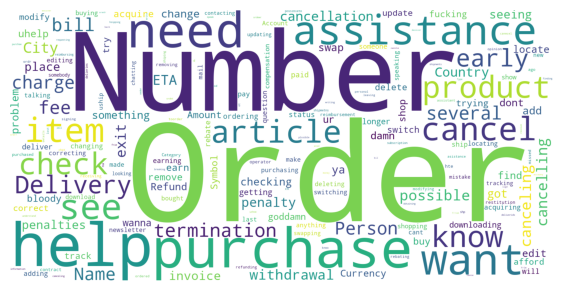

Topic № 9


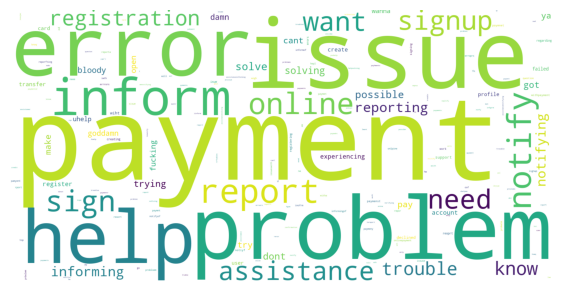

Topic № 10


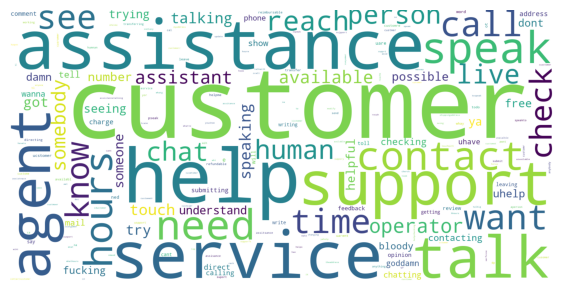

In [67]:
for i in range(best_k):
    mask = (clusters == i)
    cluster_texts = data.text[mask]
    print(f'Topic № {i}')
    create_lda_wordcloud(cluster_texts)

Из облаков разница между кластерами видна гораздо лучше. Теперь можем брать их вместе с результатами распределения обращений по кластерам и нести в технический отдел, чтобы они чинили ту часть сервиса, на которую жалуются больше всего.